In [3]:
%%capture
%run 07_Recaliberate_DistanceModulus.ipynb

In [8]:
import emcee
import corner

In [5]:
# estimate omega_M and omega_L

# calculate H(z) for all z

# speed of light
c = 9.7 * 10e-15 # Mpc/sec
z = filtered_GRB['z'].to_numpy()
H_z = c * (1. + z)**2 * np.log(1.+z) / d_L
H_z_err = abs(H_z) * d_L_err / d_L
H_0 = 67.4 # km/sec/Mpc

# 

/tmp/ipykernel_595473/902790008.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


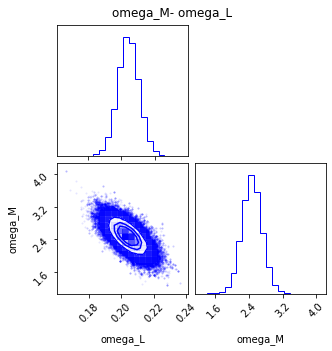

In [11]:
def log_likelihood(theta, x, y, xerr, yerr):
    b, a, sigma_int = theta
    model = b * x + a
    sigma2 = sigma_int**2 + yerr**2 + b**2 * xerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    b, a, sigma_int = theta
    if sigma_int > 0:
        return 0.0
    return -np.inf

def log_posterior(theta, x, y, xerr, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, xerr, yerr)

# MCMC parameters
nwalkers, ndim = 64, 3
nsteps, nburns = 10000, 5000


# create empty figure object for corner plots (confidence contours and marginalized PDFs of parameters)
fig2 = plt.figure(figsize=(5, 5))
fig2.patch.set_facecolor('white')

x = (1. + z)**3
y = (1. + z)**2 #(H_z / H_0)**2

xerr = 0
yerr = 0 #abs(y * 2 * H_z_err / H_z)# should errors in H_0 be considered ?

starting_guesses = np.random.rand(nwalkers, ndim)
        
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, xerr, yerr))
sampler.run_mcmc(starting_guesses, nsteps)

labels = ['omega_L', 'omega_M','sigma_int']
'''
# time series plot of parameters
samples = sampler.get_chain()
gs11 = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=1, subplot_spec=gs1[k])

for j in range(ndim):
    ax = fig1.add_subplot(gs11[j])
    ax.plot(samples[..., j], 'k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    #axes[-1].set_xlabel("step number");
'''
# corner plots
flat_samples = sampler.get_chain(discard=nburns, flat=True)
corner.corner(flat_samples[:,:2], labels=labels[:2], color='b',fig=fig2)

# save best fit values(mean) and uncertainities(std) of parameters in a dictionary
omega_M_omega_L_correlation_best_fit = {
        'omega_L' : np.mean(flat_samples[:, 1]), 
        'omega_L_err' : np.std(flat_samples[:, 1]),
        'omega_M' : np.mean(flat_samples[:, 0]), 
        'omega_M_err' : np.std(flat_samples[:, 0]),
        #'sigma_int' : np.mean(flat_samples[:, 2]),
        #'sigma_int_err' : np.std(flat_samples[:, 2])
    }

#fig2.axes[0].annotate(sample_type, xy=(0.95*2.5, 0.95-k*0.2), xycoords='axes fraction',color=color)

fig2.suptitle('omega_M- omega_L')

#fig1.savefig('time_series_of_params.png')
fig2.savefig(os.path.join(out_dir,'17_omega_M_omega_L_corner_plot.png'))
#fig1.show()
fig2.show()

/tmp/ipykernel_595473/4223977722.py:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


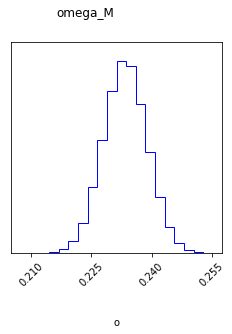

In [12]:
def log_likelihood(theta, x, y):
    b = theta
    model = b * x + 1
    return -0.5 * np.sum((y - model) ** 2)

def log_prior(theta):
    b = theta
    return 0.

def log_posterior(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)

# MCMC parameters
nwalkers, ndim = 64, 1
nsteps, nburns = 10000, 5000


# create empty figure object for corner plots (confidence contours and marginalized PDFs of parameters)
fig2 = plt.figure(figsize=(5, 5))
fig2.patch.set_facecolor('white')

x = (1. + z)**3 - 1.
y = (1. + z)**2 #(H_z / H_0)**2

xerr = 0
yerr = 0 #abs(y * 2 * H_z_err / H_z)# should errors in H_0 be considered ?

starting_guesses = np.random.rand(nwalkers, ndim)
        
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y))
sampler.run_mcmc(starting_guesses, nsteps)

labels = ['omega_L', 'omega_M','sigma_int']
'''
# time series plot of parameters
samples = sampler.get_chain()
gs11 = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=1, subplot_spec=gs1[k])

for j in range(ndim):
    ax = fig1.add_subplot(gs11[j])
    ax.plot(samples[..., j], 'k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    #axes[-1].set_xlabel("step number");
'''
# corner plots
flat_samples = sampler.get_chain(discard=nburns, flat=True)
corner.corner(flat_samples, labels='omega_M', color='b',fig=fig2)

# save best fit values(mean) and uncertainities(std) of parameters in a dictionary
omega_M_omega_L_correlation_best_fit = {
        'omega_L' : np.mean(flat_samples), 
        'omega_L_err' : np.std(flat_samples),
        'omega_M' : np.mean(flat_samples), 
        'omega_M_err' : np.std(flat_samples),
        #'sigma_int' : np.mean(flat_samples[:, 2]),
        #'sigma_int_err' : np.std(flat_samples[:, 2])
    }

#fig2.axes[0].annotate(sample_type, xy=(0.95*2.5, 0.95-k*0.2), xycoords='axes fraction',color=color)

fig2.suptitle('omega_M')

#fig1.savefig('time_series_of_params.png')
fig2.savefig(os.path.join(out_dir,'18_omega_M_corner_plot.png'))
#fig1.show()
fig2.show()

In [13]:
print('omega_M = {}'.format(omega_M_omega_L_correlation_best_fit['omega_M']))
print('omega_M_err = {}'.format(omega_M_omega_L_correlation_best_fit['omega_M_err']))

#print('omega_L = {}'.format(omega_M_omega_L_correlation_best_fit['omega_L']))
#print('omega_L_err = {}'.format(omega_M_omega_L_correlation_best_fit['omega_L_err']))

omega_M = 0.23343397950885791
omega_M_err = 0.005472385112667081
